In [1]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
%matplotlib inline
# from renderFace import renderFace

# faceBlendCommon

In [2]:
import cv2
import dlib
import numpy as np
import math

# Returns 8 points on the boundary of a rectangle
def getEightBoundaryPoints(h, w):
  boundaryPts = []
  boundaryPts.append((0,0))
  boundaryPts.append((w/2, 0))
  boundaryPts.append((w-1,0))
  boundaryPts.append((w-1, h/2))
  boundaryPts.append((w-1, h-1))
  boundaryPts.append((w/2, h-1))
  boundaryPts.append((0, h-1))
  boundaryPts.append((0, h/2))
  return np.array(boundaryPts, dtype=np.float)


# Constrains points to be inside boundary
def constrainPoint(p, w, h):
  p = (min(max(p[0], 0), w - 1), min(max(p[1], 0), h - 1))
  return p

# convert Dlib shape detector object to list of tuples
def dlibLandmarksToPoints(shape):
  points = []
  for p in shape.parts():
    pt = (p.x, p.y)
    points.append(pt)
  return points

# Compute similarity transform given two sets of two points.
# OpenCV requires 3 pairs of corresponding points.
# We are faking the third one.
def similarityTransform(inPoints, outPoints):
  s60 = math.sin(60*math.pi/180)
  c60 = math.cos(60*math.pi/180)

  inPts = np.copy(inPoints).tolist()
  outPts = np.copy(outPoints).tolist()

  # The third point is calculated so that the three points make an equilateral triangle
  xin = c60*(inPts[0][0] - inPts[1][0]) - s60*(inPts[0][1] - inPts[1][1]) + inPts[1][0]
  yin = s60*(inPts[0][0] - inPts[1][0]) + c60*(inPts[0][1] - inPts[1][1]) + inPts[1][1]

  inPts.append([np.int(xin), np.int(yin)])

  xout = c60*(outPts[0][0] - outPts[1][0]) - s60*(outPts[0][1] - outPts[1][1]) + outPts[1][0]
  yout = s60*(outPts[0][0] - outPts[1][0]) + c60*(outPts[0][1] - outPts[1][1]) + outPts[1][1]

  outPts.append([np.int(xout), np.int(yout)])

  # Now we can use estimateRigidTransform for calculating the similarity transform.
  tform = cv2.estimateAffinePartial2D(np.array([inPts]), np.array([outPts]))
  return tform[0]
    
# Normalizes a facial image to a standard size given by outSize.
# Normalization is done based on Dlib's landmark points passed as pointsIn
# After normalization, left corner of the left eye is at (0.3 * w, h/3 )
# and right corner of the right eye is at ( 0.7 * w, h / 3) where w and h
# are the width and height of outSize.
def normalizeImagesAndLandmarks(outSize, imIn, pointsIn):
  h, w = outSize
  print(f"(HxW)={outSize} not matching with video frames shape={imIn.shape}")
  # Corners of the eye in input image
  if len(pointsIn) == 68:
    eyecornerSrc = [pointsIn[36], pointsIn[45]]
  elif len(pointsIn) == 5:
    eyecornerSrc = [pointsIn[2], pointsIn[0]]
  else:
    print(f"(H x W)={outSize} not matching with video frames shape={imIn.shape}")

  # Corners of the eye in normalized image
  eyecornerDst = [(np.int(0.3 * w), np.int(h/3)),
                  (np.int(0.7 * w), np.int(h/3))]

  # Calculate similarity transform
  tform = similarityTransform(eyecornerSrc, eyecornerDst)
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Apply similarity transform to input image
  imOut = cv2.warpAffine(imIn, tform, (w, h))

  # reshape pointsIn from numLandmarks x 2 to numLandmarks x 1 x 2
  points2 = np.reshape(pointsIn, (pointsIn.shape[0], 1, pointsIn.shape[1]))

  # Apply similarity transform to landmarks
  pointsOut = cv2.transform(points2, tform)

  # reshape pointsOut to numLandmarks x 2
  pointsOut = np.reshape(pointsOut, (pointsIn.shape[0], pointsIn.shape[1]))

  return imOut, pointsOut

# find the point closest to an array of points
# pointsArray is a Nx2 and point is 1x2 ndarray
def findIndex(pointsArray, point):
  dist = np.linalg.norm(pointsArray-point, axis=1)
  minIndex = np.argmin(dist)
  return minIndex


# Check if a point is inside a rectangle
def rectContains(rect, point):
  if point[0] < rect[0]:
    return False
  elif point[1] < rect[1]:
    return False
  elif point[0] > rect[2]:
    return False
  elif point[1] > rect[3]:
    return False
  return True


# Calculate Delaunay triangles for set of points
# Returns the vector of indices of 3 points for each triangle
def calculateDelaunayTriangles(rect, points):

  # Create an instance of Subdiv2D
  subdiv = cv2.Subdiv2D(rect)

  # Insert points into subdiv
  for p in points:
    subdiv.insert((p[0], p[1]))

  # Get Delaunay triangulation
  triangleList = subdiv.getTriangleList()

  # Find the indices of triangles in the points array
  delaunayTri = []

  for t in triangleList:
    # The triangle returned by getTriangleList is
    # a list of 6 coordinates of the 3 points in
    # x1, y1, x2, y2, x3, y3 format.
    # Store triangle as a list of three points
    pt = []
    pt.append((t[0], t[1]))
    pt.append((t[2], t[3]))
    pt.append((t[4], t[5]))

    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])

    if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
      # Variable to store a triangle as indices from list of points
      ind = []
      # Find the index of each vertex in the points list
      for j in range(0, 3):
        for k in range(0, len(points)):
          if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
            ind.append(k)
        # Store triangulation as a list of indices
      if len(ind) == 3:
        delaunayTri.append((ind[0], ind[1], ind[2]))

  return delaunayTri

# Apply affine transform calculated using srcTri and dstTri to src and
# output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size):

  # Given a pair of triangles, find the affine transform.
  warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri))

  # Apply the Affine Transform just found to the src image
  dst = cv2.warpAffine(src, warpMat, (size[0], size[1]), None,
             flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

  return dst

# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2):
  # Find bounding rectangle for each triangle
  r1 = cv2.boundingRect(np.float32([t1]))
  r2 = cv2.boundingRect(np.float32([t2]))

  # Offset points by left top corner of the respective rectangles
  t1Rect = []
  t2Rect = []
  t2RectInt = []

  for i in range(0, 3):
    t1Rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
    t2Rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
    t2RectInt.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))

  # Get mask by filling triangle
  mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
  cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0)

  # Apply warpImage to small rectangular patches
  img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]

  size = (r2[2], r2[3])

  img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)

  img2Rect = img2Rect * mask

  # Copy triangular region of the rectangular patch to the output image
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ((1.0, 1.0, 1.0) - mask)
  img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect

# detect facial landmarks in image
def getLandmarks(faceDetector, landmarkDetector, im, FACE_DOWNSAMPLE_RATIO = 1):
  points = []
  imSmall = cv2.resize(im,None,
                       fx=1.0/FACE_DOWNSAMPLE_RATIO,
                       fy=1.0/FACE_DOWNSAMPLE_RATIO,
                       interpolation = cv2.INTER_LINEAR)

  faceRects = faceDetector(imSmall, 0)

  if len(faceRects) > 0:
    maxArea = 0
    maxRect = None
    # TODO: test on images with multiple faces
    for face in faceRects:
      if face.area() > maxArea:
        maxArea = face.area()
        maxRect = [face.left(),
                   face.top(),
                   face.right(),
                   face.bottom()
                  ]

    rect = dlib.rectangle(*maxRect)
    scaledRect = dlib.rectangle(int(rect.left()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.top()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.right()*FACE_DOWNSAMPLE_RATIO),
                             int(rect.bottom()*FACE_DOWNSAMPLE_RATIO))

    landmarks = landmarkDetector(im, scaledRect)
    points = dlibLandmarksToPoints(landmarks)
  return points

# Warps an image in a piecewise affine manner.
# The warp is defined by the movement of landmark points specified by pointsIn
# to a new location specified by pointsOut. The triangulation beween points is specified
# by their indices in delaunayTri.
def warpImage(imIn, pointsIn, pointsOut, delaunayTri):
  h, w, ch = imIn.shape
  # Output image
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Warp each input triangle to output triangle.
  # The triangulation is specified by delaunayTri
  for j in range(0, len(delaunayTri)):
    # Input and output points corresponding to jth triangle
    tin = []
    tout = []

    for k in range(0, 3):
      # Extract a vertex of input triangle
      pIn = pointsIn[delaunayTri[j][k]]
      # Make sure the vertex is inside the image.
      pIn = constrainPoint(pIn, w, h)

      # Extract a vertex of the output triangle
      pOut = pointsOut[delaunayTri[j][k]]
      # Make sure the vertex is inside the image.
      pOut = constrainPoint(pOut, w, h)

      # Push the input vertex into input triangle
      tin.append(pIn)
      # Push the output vertex into output triangle
      tout.append(pOut)

    # Warp pixels inside input triangle to output triangle.
    warpTriangle(imIn, imOut, tin, tout)
  return imOut


In [3]:
import cv2
import numpy as np


def drawPolyline(im, landmarks, start, end, isClosed=False):
  points = []
  for i in range(start, end+1):
    point = [landmarks.part(i).x, landmarks.part(i).y]
    points.append(point)

  points = np.array(points, dtype=np.int32)
  cv2.polylines(im, [points], isClosed, (255, 200, 0), thickness=2, lineType=cv2.LINE_8)

# Use this function for 70-points facial landmark detector model
def renderFace(im, landmarks):
    assert(landmarks.num_parts == 68)
    drawPolyline(im, landmarks, 0, 16)           # Jaw line
    drawPolyline(im, landmarks, 17, 21)          # Left eyebrow
    drawPolyline(im, landmarks, 22, 26)          # Right eyebrow
    drawPolyline(im, landmarks, 27, 30)          # Nose bridge
    drawPolyline(im, landmarks, 30, 35, True)    # Lower nose
    drawPolyline(im, landmarks, 36, 41, True)    # Left eye
    drawPolyline(im, landmarks, 42, 47, True)    # Right Eye
    drawPolyline(im, landmarks, 48, 59, True)    # Outer lip
    drawPolyline(im, landmarks, 60, 67, True)    # Inner lip

# Use this function for any model other than
# 70 points facial_landmark detector model
def renderFace2(im, landmarks, color=(0, 255, 0), radius=3):
  for p in landmarks.parts():
    cv2.circle(im, (p.x, p.y), radius, color, -1)

In [4]:
def normalizeImagesAndLandmarks(outSize, imIn, pointsIn):
  h, w = outSize

  # Corners of the eye in input image
  if len(pointsIn) == 68:
    eyecornerSrc = [pointsIn[36], pointsIn[45]]
  elif len(pointsIn) == 5:
    eyecornerSrc = [pointsIn[2], pointsIn[0]]

  # Corners of the eye in normalized image
  eyecornerDst = [(np.int(0.3 * w), np.int(h/3)),
                  (np.int(0.7 * w), np.int(h/3))]

  # Calculate similarity transform
  tform = similarityTransform(eyecornerSrc, eyecornerDst)
  imOut = np.zeros(imIn.shape, dtype=imIn.dtype)

  # Apply similarity transform to input image
  imOut = cv2.warpAffine(imIn, tform, (w, h))

  # reshape pointsIn from numLandmarks x 2 to numLandmarks x 1 x 2
  points2 = np.reshape(pointsIn, 
                      (pointsIn.shape[0], 1, pointsIn.shape[1]))

  # Apply similarity transform to landmarks
  pointsOut = cv2.transform(points2, tform)

  # reshape pointsOut to numLandmarks x 2
  pointsOut = np.reshape(pointsOut, 
                          (pointsIn.shape[0], pointsIn.shape[1]))

  return imOut, pointsOut

In [5]:
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [6]:
def writeLandmarksToFile(landmarks, landmarksFileName):
  with open(landmarksFileName, 'w') as f:
    for p in landmarks.parts():
      f.write("%s %s\n" %(int(p.x),int(p.y)))
  f.close()

In [7]:
# from google.colab import files
# files.upload()
# # !wget https://github.com/AKSHAYUBHAT/TensorFace/blob/master/openface/models/dlib/shape_predictor_68_face_landmarks.dat

In [8]:
PREDICTOR_68_PATH = "shape_predictor_68_face_landmarks.dat"
PREDICTOR_5_PATH = "./shape_predictor_5_face_landmarks.dat"

In [9]:
# faceDetector = dlib.get_frontal_face_detector()

In [10]:
# !unzip video_frames.zip
# !mkdir results
# !mkdir results/video

In [11]:
# # The landmark detector is implemented in the shape_predictor class
# landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

# # Read image
# imageFilename = "video_frames/video_000.jpg"
# im= cv2.imread(imageFilename)

# # landmarks will be stored in results/family_i.txt
# landmarksBasename = "results/video"


In [12]:
# # Detect faces in the image
# faceRects = faceDetector(im, 0)
# print("Number of faces detected: ",len(faceRects))

# # List to store landmarks of all detected faces
# landmarksAll = []

# Five point detector

In [13]:
# from google.colab import files
# files.upload()
#upload faceBlendCommon.py

In [14]:
#Download five point "shape_predictor_5_face_landmarks.dat"
# from google.colab import files
# files.upload()
#if it not downloding use "https://github.com/davisking/dlib-models/blob/master/shape_predictor_5_face_landmarks.dat.bz2"
# !wget https://github.com/justadudewhohacks/face-recognition.js-models/blob/master/models/shape_predictor_5_face_landmarks.dat

In [15]:

# import faceBlendCommon as fbc
DATA_PATH = "./"
MODEL_PATH = "./"
# from dataPath import DATA_PATH
# from dataPath import MODEL_PATH
# import matplotlib.pyplot as plt
# %matplotlib inline

In [16]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [17]:
# PREDICTOR_PATH = "./shape_predictor_5_face_landmarks.dat"

In [18]:
# Get the face detector
faceDetector = dlib.get_frontal_face_detector()
# The landmark detector is implemented in the shape_predictor class
landmarkDetector_5_point = dlib.shape_predictor(PREDICTOR_5_PATH)
landmarkDetector_68_point = dlib.shape_predictor(PREDICTOR_68_PATH)

In [19]:
def drow_circle_points(img, pointsOut):
    imgs  = np.copy(img)
    for (x, y) in pointsOut:
        imgs = cv2.circle(imgs, (x, y), 2, (0, 255, 0), -1)
    return imgs

In [20]:
640/2

320.0

# Video Stream(WebCam Check)

In [9]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('input_1.avi',fourcc, 20.0, (640,480))
print("Starting...")
while True:
    ret, frame = cap.read()
    if ret==True:
        out.write(frame)
        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord(' '):
            break
    else:
        break
# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

Starting...


In [ ]:
import numpy as np
import cv2

cap = cv2.VideoCapture(0)
h = 480
w = 320
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))
print("Starting...")
while True:
    ret, frame = cap.read()
    if ret==True:
        points_5 = getLandmarks(faceDetector, landmarkDetector_5_point, frame)
        points_5 = np.array(points_5)

        points_68 = getLandmarks(faceDetector, landmarkDetector_68_point, frame)
        points_68 = np.array(points_68)

        if len(points_5)==5 or len(points_68)==68:
#         if len(points_5)==5:
    #         print(len(points))
            imNorm5, points_5 = normalizeImagesAndLandmarks((h, w), np.float32(frame)/255.0, points_5)
            imNorm5 = np.uint8(imNorm5*255)

            imNorm68, points_68 = normalizeImagesAndLandmarks((h, w), np.float32(frame)/255.0, points_68)
            imNorm68 = np.uint8(imNorm68*255)

            img_with_5_point = drow_circle_points(imNorm5, points_5)
            img_with_68_point = drow_circle_points(imNorm68, points_68)
            vis = np.concatenate((img_with_5_point,img_with_68_point), axis=1)
#         Display the resulting frame
#             cv2.imshow('frame',img_with_5_point)
        # write the flipped frame
#             print(frame.shape)
#             print(vis.shape)
            out.write(vis)
            cv2.imshow('frame',vis)
            if cv2.waitKey(1) & 0xFF == ord(' '):
                break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
from __future__ import print_function
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
 
# construct the argument parse and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-o", "--output", required=True,
# 	help="path to output video file")
# ap.add_argument("-p", "--picamera", type=int, default=-1,
# 	help="whether or not the Raspberry Pi camera should be used")
# ap.add_argument("-f", "--fps", type=int, default=20,
# 	help="FPS of output video")
# ap.add_argument("-c", "--codec", type=str, default="MJPG",
# 	help="codec of output video")
# args = vars(ap.parse_args())



# initialize the video stream and allow the camera
# sensor to warmup
print("[INFO] warming up camera...")
vs = VideoStream(0).start()
time.sleep(2.0)
 
# initialize the FourCC, video writer, dimensions of the frame, and
# zeros array
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
writer = None
(h, w) = (None, None)
zeros = None

# loop over frames from the video stream
while True:
	# grab the frame from the video stream and resize it to have a
	# maximum width of 300 pixels
	frame = vs.read()
	frame = imutils.resize(frame, width=300)
 
	# check if the writer is None
	if writer is None:
		# store the image dimensions, initialize the video writer,
		# and construct the zeros array
		(h, w) = frame.shape[:2]
		writer = cv2.VideoWriter('kk.avi', fourcc, 40,
			(w * 2, h * 2), True)
		zeros = np.zeros((h, w), dtype="uint8")

        
	(B, G, R) = cv2.split(frame)
	R = cv2.merge([zeros, zeros, R])
	G = cv2.merge([zeros, G, zeros])
	B = cv2.merge([B, zeros, zeros])
 
	# construct the final output frame, storing the original frame
	# at the top-left, the red channel in the top-right, the green
	# channel in the bottom-right, and the blue channel in the
	# bottom-left
	output = np.zeros((h * 2, w * 2, 3), dtype="uint8")
	output[0:h, 0:w] = frame
	output[0:h, w:w * 2] = R
	output[h:h * 2, w:w * 2] = G
	output[h:h * 2, 0:w] = B
 
	# write the output frame to file
	writer.write(output)
    
	# show the frames
	cv2.imshow("Frame", frame)
	cv2.imshow("Output", output)
	key = cv2.waitKey(1) & 0xFF
 
	# if the `q` key was pressed, break from the loop
	if key == ord("q"):
		break
 
# do a bit of cleanup
print("[INFO] cleaning up...")

vs.stop()
writer.release()
cv2.destroyAllWindows()

[INFO] warming up camera...


In [27]:
# Detect landmarks.
import numpy as np
import cv2

h = 600
w = 400
# faceDetector = dlib.get_frontal_face_detector()
#  The landmark detector is implemented in the shape_predictor class
# landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
        # Our operations on the frame come here
    #     gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    points_5 = getLandmarks(faceDetector, landmarkDetector_5_point, frame)
    points_5 = np.array(points_5)
    
    points_68 = getLandmarks(faceDetector, landmarkDetector_68_point, frame)
    points_68 = np.array(points_68)
    
#     if len(points_5)==5 or len(points_68)==68:
    if len(points_5)==5:
#         print(len(points))
        imNorm5, points_5 = normalizeImagesAndLandmarks((h, w), np.float32(frame)/255.0, points_5)
        imNorm5 = np.uint8(imNorm5*255)
        
        imNorm68, points_68 = normalizeImagesAndLandmarks((h, w), np.float32(frame)/255.0, points_68)
        imNorm68 = np.uint8(imNorm68*255)
        
        img_with_5_point = drow_circle_points(imNorm5, points_5)
        img_with_68_point = drow_circle_points(imNorm68, points_68)
        vis = np.concatenate((imNorm5, img_with_5_point, img_with_68_point), axis=1)
        
    # Display the resulting frame
        
        cv2.imshow('frame', vis)
        if cv2.waitKey(1) & 0xFF == ord(' ') :
            print(frame.shape)
            break
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()


(480, 640, 3)


In [25]:

im = cv2.imread('./krunal(3).jpg') 
points = getLandmarks(faceDetector, landmarkDetector, im)
points = np.array(points)


NameError: name 'landmarkDetector' is not defined

In [ ]:
# Convert image to floating point in the range 0 to 1
im = np.float32(im)/255.0

In [ ]:
# Dimensions of output image
#120, 160
h = 600
w = 600

In [4]:
# imNorm, points = normalizeImagesAndLandmarks((h, w), im, points)

In [29]:
imNorm = np.uint8(imNorm*255)

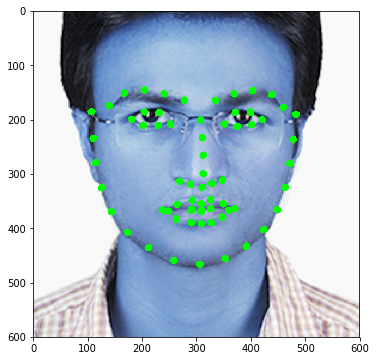

In [34]:
plt.imshow(drow_circle_points(imNorm, points))

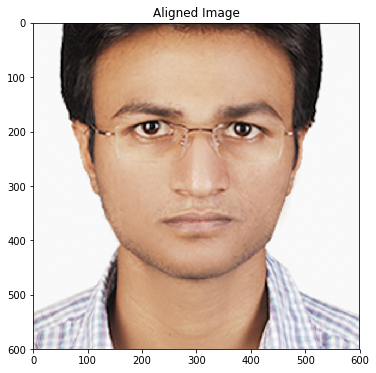

In [27]:
plt.imshow(imNorm[:,:,::-1])
plt.title("Aligned Image")
plt.show()

# Cont.

In [38]:
outSize = (600, 600)
imIn = imNorm
pointsIn = points
imOut, pointsOut = normalizeImagesAndLandmarks(outSize, imIn, pointsIn)

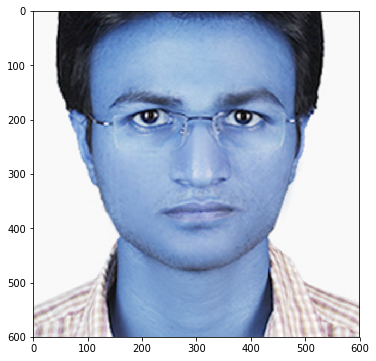

In [39]:
plt.imshow(imOut)
# pointsOut

In [40]:
from imutils import face_utils

In [45]:

 
# loop over the (x, y)-coordinates for the facial landmarks
# and draw them on the image
def drow_circle_points(img, pointsOut):
    imgs  = np.copy(img)
    for (x, y) in pointsOut:
        imgs = cv2.circle(imgs, (x, y), 7, (255, 0, 0), -1)
    return imgs

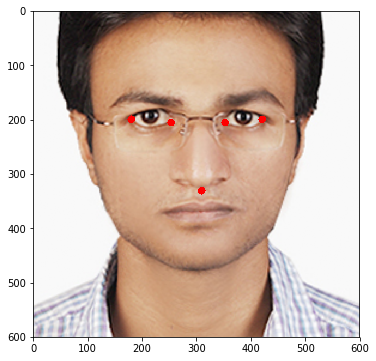

In [46]:
img1 = drow_circle_points(imNorm[:,:,::-1] ,pointsOut)
img2 = drow_circle_points(imOut ,pointsOut)
plt.imshow(drow_circle_points(imNorm[:,:,::-1] ,pointsOut))
# pointsOut

In [47]:
vis = np.concatenate((img1, img2), axis=1)

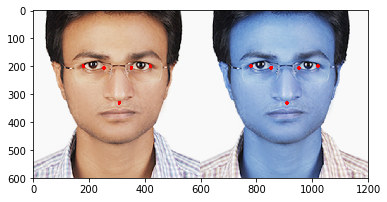

In [48]:
plt.imshow(vis)

# Optical Flow(Stabilization)

In [1]:
import cv2, dlib
import numpy as np
import math, sys
# from dataPath import DATA_PATH
# from dataPath import MODEL_PATH
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
matplotlib.rcParams['image.cmap'] = 'gray'

In [3]:
PREDICTOR_PATH = "./shape_predictor_68_face_landmarks.dat"
RESIZE_HEIGHT = 480
NUM_FRAMES_FOR_FPS = 100
SKIP_FRAMES = 1

In [4]:
# Function to calculate the intereye distance.
def interEyeDistance(predict):
  leftEyeLeftCorner = (predict[36].x, predict[36].y)
  rightEyeRightCorner = (predict[45].x, predict[45].y)
  distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
  distance = int(distance)
  return distance

In [5]:
winName = "Stabilized facial landmark detector"

In [6]:
videoFileName = "./input_1.avi"

# Initializing video capture object.
cap = cv2.VideoCapture(0)

if(cap.isOpened()==False):
  print("Unable to load video")

In [7]:
winSize = 101
maxLevel = 10
fps = 30.0
# Grab a frame
ret,imPrev = cap.read()
# Finding the size of the image.
size = imPrev.shape[0:1]
detector = dlib.get_frontal_face_detector()
# PREDICTOR_PATH = PREDICTOR_5
landmarkDetector = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')
# Initializing the parameters

points=[]
pointsPrev=[]
pointsDetectedCur=[]
pointsDetectedPrev=[]

eyeDistanceNotCalculated = True
eyeDistance = 0
isFirstFrame = True
# Initial value, actual value calculated after 100 frames
fps = 10
showStabilized = False
count =0

In [ ]:
while(True):
  if (count==0):
    t = cv2.getTickCount()

  # Grab a frame
  ret,im = cap.read()
  imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # COnverting to grayscale
  imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  height = im.shape[0]
  IMAGE_RESIZE = float(height)/RESIZE_HEIGHT
  # Resize image for faster face detection
  imSmall = cv2.resize(im, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
  imSmallDlib = cv2.cvtColor(imSmall, cv2.COLOR_BGR2RGB)
  # Skipping the frames for faster processing
  if (count % SKIP_FRAMES == 0):
    faces = detector(imSmallDlib,0)

  # If no face was detected
  if len(faces)==0:
    print("No face detected")

  # If faces are detected, iterate through each image and detect landmark points
  else:
    for i in range(0,len(faces)):
#       print("face detected")
      # Face detector was found over a smaller image.
      # So, we scale face rectangle to correct size.
      newRect = dlib.rectangle(int(faces[i].left() * IMAGE_RESIZE),
        int(faces[i].top() * IMAGE_RESIZE),
        int(faces[i].right() * IMAGE_RESIZE),
        int(faces[i].bottom() * IMAGE_RESIZE))
      
      # Detect landmarks in current frame
      landmarks = landmarkDetector(imDlib, newRect).parts()
      
      # Handling the first frame of video differently,for the first frame copy the current frame points
      
      if (isFirstFrame==True):
        pointsPrev=[]
        pointsDetectedPrev = []
        [pointsPrev.append((p.x, p.y)) for p in landmarks]
        [pointsDetectedPrev.append((p.x, p.y)) for p in landmarks]

      # If not the first frame, copy points from previous frame.
      else:
        pointsPrev=[]
        pointsDetectedPrev = []
        pointsPrev = points
        pointsDetectedPrev = pointsDetectedCur

      # pointsDetectedCur stores results returned by the facial landmark detector
      # points stores the stabilized landmark points
      points = []
      pointsDetectedCur = []
      [points.append((p.x, p.y)) for p in landmarks]
      [pointsDetectedCur.append((p.x, p.y)) for p in landmarks]

      # Convert to numpy float array
      pointsArr = np.array(points,np.float32)
      pointsPrevArr = np.array(pointsPrev,np.float32)

      # If eye distance is not calculated before
      if eyeDistanceNotCalculated:
        eyeDistance = interEyeDistance(landmarks)
#         print(eyeDistance)
        eyeDistanceNotCalculated = False

      if eyeDistance > 100:
          dotRadius = 3
      else:
        dotRadius = 2

#       print(eyeDistance)
      sigma = eyeDistance * eyeDistance / 400
      s = 2*int(eyeDistance/4)+1

      #  Set up optical flow params
      lk_params = dict(winSize  = (s, s), maxLevel = 5, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
      # Python Bug. Calculating pyramids and then calculating optical flow results in an error. So directly images are used.
#       ret, imGrayPrev= cv2.buildOpticalFlowPyramid(imGray, (winSize,winSize), maxLevel)
#       print(imDlib.shape,imGray.shape)
      pointsArr,status, err = cv2.calcOpticalFlowPyrLK(im,imDlib,pointsPrevArr,pointsArr,**lk_params)
      

      # Converting to float
      pointsArrFloat = np.array(pointsArr,np.float32)

      # Converting back to list
      points = pointsArrFloat.tolist()

      # Final landmark points are a weighted average of
      # detected landmarks and tracked landmarks
      for k in range(0,len(landmarks)):
        d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
        alpha = math.exp(-d*d/sigma)
        points[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points[k])

      # Drawing over the stabilized landmark points
      if showStabilized is True:
        for p in points:
          cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (255,0,0),-1)
      else:
        for p in pointsDetectedCur:
          cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (0,0,255),-1)

      isFirstFrame = False
      count = count+1

      # Calculating the fps value
      if ( count == NUM_FRAMES_FOR_FPS):
        t = (cv2.getTickCount()-t)/cv2.getTickFrequency()
        fps = NUM_FRAMES_FOR_FPS/t
        count = 0
        isFirstFrame = True

      # Display the landmarks points
      cv2.putText(im, "{:.1f}-fps".format(fps), (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3,cv2.LINE_AA)
      cv2.imshow(winName, im)
      if cv2.waitKey(1) & 0xFF == ord('q'):
        showStabilized = not showStabilized

      key = cv2.waitKey(25) & 0xFF

      # Use spacebar to toggle between Stabilized and Unstabilized version.
      if key==32:
        showStabilized = not showStabilized

      # Stop the program.
      if key==27:
        print("ok")
        sys.exit()
      # Getting ready for next frame
      imPrev = im
      imGrayPrev = imGray

cv2.destroyAllwindows()
cap.release()

No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected
No face detected


In [1]:
# cv2.calcOpticalFlowPyrLK